In [1]:
import numpy as np
import subprocess
from datetime import datetime, timedelta
import multiprocessing as mp
import sys, time
from countdown import countdown
import av
import glob
import serial
from tqdm import tqdm

In [2]:
from multicamera_acquisition.interfaces.arduino import (
    packIntAsLong,
    wait_for_serial_confirmation,
)

/home/dattalab/code/multicamera_acquisition/multicamera_acquisition/interfaces/arduino.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from pypylon import pylon

In [4]:
#from llpyspin import secondary, primary
import numpy as np
import matplotlib.pyplot as plt
import os, time, serial, glob, struct

def packIntAsLong(value):
    """Packs a python 4 byte integer to an arduino long"""
    return struct.pack('i', value)


In [5]:
    
def get_timing_params(duration, framerate, exposure_time, buffer=50):
    
    inv_framerate = int(1e6/framerate)
    num_cycles = int(duration * framerate / 2)
    
    params = (
        num_cycles,
        exposure_time,
        inv_framerate,
    )
    
    return params
    

In [6]:
prefix = '../../data/test'

recording_duration_s = 10
framerate = 30
exposure_time = 2000
serial_timeout_duration_s=0.1


In [7]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

In [8]:
# demonstrate some feature accessdi.SetSerialNumber("2134234")
new_width = camera.Width.GetValue() - camera.Width.GetInc()
if new_width >= camera.Width.GetMin():
    camera.Width.SetValue(new_width)

In [10]:
camera.TriggerSource.SetValue("Line3")
camera.TriggerMode.SetValue("On")

In [11]:
numberOfImagesToGrab = 5self.tlf = py.TlFactory.GetInstance()
camera.StartGrabbingMax(numberOfImagesToGrab)

In [12]:
# prepare communication with arduino
serial_ports = glob.glob("/dev/ttyACM*")
# check that there is an arduino available
if len(serial_ports) == 0:
    raise ValueError("No serial device (i.e. Arduino) available to capture frames")
port = glob.glob("/dev/ttyACM*")[0]
arduino = serial.Serial(port=port, timeout=serial_timeout_duration_s)

# delay recording to allow serial connection to connect
time.sleep(1.0)

In [13]:
# Tell the arduino to start recording by sending along the recording parameters
inv_framerate = int(1e6 / framerate)
num_cycles = int(recording_duration_s * framerate / 2)
msg = b"".join(
    map(
        packIntAsLong,
        (
            num_cycles,
            exposure_time,
            inv_framerate,
        ),
    )
)
arduino.write(msg)

# Run acquision
confirmation = wait_for_serial_confirmation(arduino, "Start")
# how long to record
datetime_prev = datetime.now()
endtime = datetime_prev + timedelta(seconds=recording_duration_s + 10)
# while current time is less than initial time + recording_duration_s
pbar = tqdm(total=recording_duration_s, desc="recording progress (s)")
while datetime.now() < endtime:
    confirmation = arduino.readline().decode("utf-8").strip("\r\n")
    if (datetime.now() - datetime_prev).seconds > 0:
        pbar.update((datetime.now() - datetime_prev).seconds)
        datetime_prev = datetime.now()
    while camera.IsGrabbing():
        grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
        if grabResult.GrabSucceeded():
            # Access the image data.
            print("SizeX: ", grabResult.Width)
            print("SizeY: ", grabResult.Height)
            img = grabResult.Array
            print("Gray value of first pixel: ", img[0, 0])

        grabResult.Release()
    camera.Close()

    if confirmation == "Finished":
        print("End Acquisition")
        break

pbar.close()

Confirmation recieved: Start


recording progress (s):   0%|                                                          | 0/10 [00:00<?, ?it/s]

SizeX:  1008
SizeY:  1024
Gray value of first pixel:  4
SizeX:  1008
SizeY:  1024
Gray value of first pixel:  4
SizeX:  1008
SizeY:  1024
Gray value of first pixel:  4
SizeX:  1008
SizeY:  1024
Gray value of first pixel:  4
SizeX:  1008
SizeY:  1024
Gray value of first pixel:  3


recording progress (s):  90%|█████████████████████████████████████████████     | 9/10 [00:09<00:01,  1.10s/it]

End Acquisition


In [14]:
camera.Close()

In [15]:
import matplotlib.pyplot as plt

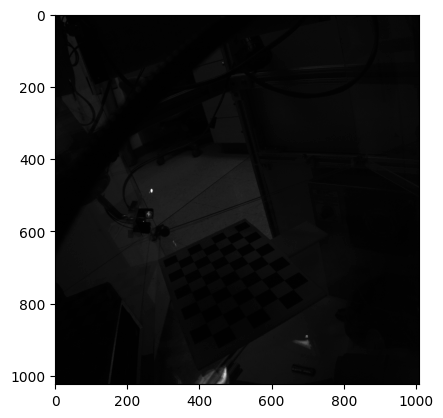

In [16]:
plt.imshow(img, cmap = plt.cm.Greys_r)